<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/torchvision_transforms_v2_bbox_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# helpers from https://github.com/pytorch/vision/tree/main/gallery/

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [59]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode

In [60]:
!wget -O cat2.png https://github.com/aruaru0/pytorch-tests/blob/main/cat2.png?raw=true

--2023-11-30 07:10:13--  https://github.com/aruaru0/pytorch-tests/blob/main/cat2.png?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aruaru0/pytorch-tests/raw/main/cat2.png [following]
--2023-11-30 07:10:14--  https://github.com/aruaru0/pytorch-tests/raw/main/cat2.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aruaru0/pytorch-tests/main/cat2.png [following]
--2023-11-30 07:10:14--  https://raw.githubusercontent.com/aruaru0/pytorch-tests/main/cat2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638240 

In [61]:
img = read_image('cat2.png', ImageReadMode.RGB)
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 768, 512])


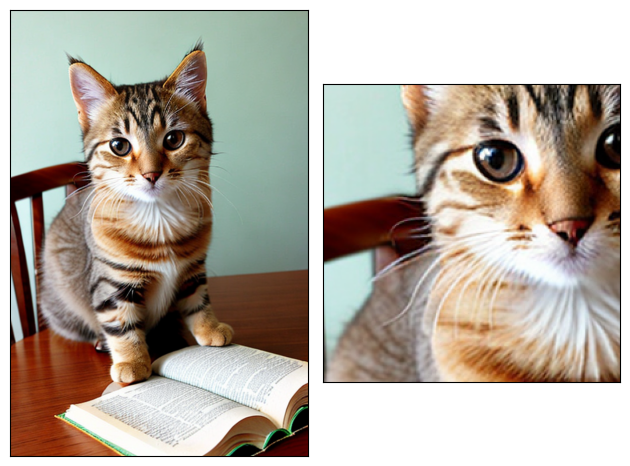

In [62]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

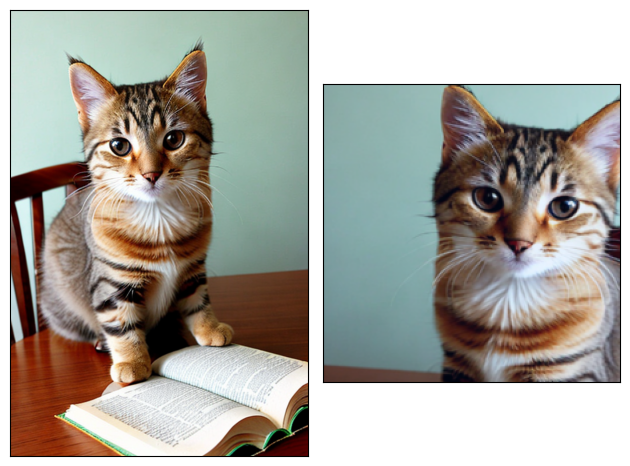

In [63]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

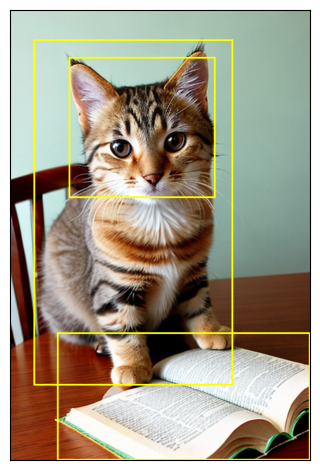

In [64]:
from torchvision import tv_tensors

boxes = tv_tensors.BoundingBoxes(
    [
        [40, 50, 380, 640],
        [80, 550, 512, 768],
        [100, 80, 350, 320]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

plot([(img, boxes)])

<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


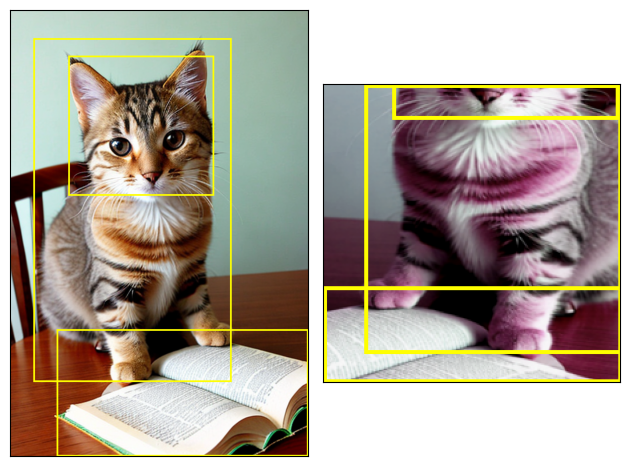

In [65]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])

In [66]:
out_boxes

BoundingBoxes([[ 31,   0, 224, 202],
               [  0, 152, 224, 224],
               [ 52,   0, 222,  26]], format=BoundingBoxFormat.XYXY, canvas_size=(224, 224))

{'boxes': BoundingBoxes([[ 56,   0, 224, 177],
                [  0, 126, 224, 224]], format=BoundingBoxFormat.XYXY, canvas_size=(224, 224)),
 'labels': tensor([0, 1])}

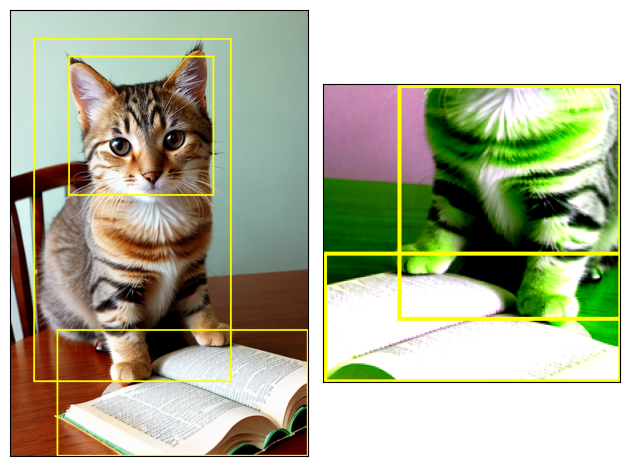

In [68]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
    v2.SanitizeBoundingBoxes(min_size=1),
])

target = {
    "boxes": boxes,
    "labels": torch.arange(boxes.shape[0]),
}

# Re-using the transforms and definitions from above.
out_img, out_target = transforms(img, target)

plot([(img, target["boxes"]), (out_img, out_target["boxes"])])
out_target